# Esport - Prediction using a neural network

This jupyter notebook can be found here https://drive.google.com/file/d/1pSjUtsf3tacWbv0bdXDcfGVdhrHg4pJx/view?usp=sharing

- Demo file: https://drive.google.com/file/d/1AVZ3IdrN-TCkclVUcSEyjwrYMH58aqWe/view?usp=sharing

Project requirements:
<br>numpy
<br>pandas
<br>scikit-learn
<br>keras
<br>matplotlib
<br>seaborn
<br>demoparser2
<br>jupyterlab
<br>tensorflow

Useful links:
- HLTV results - https://www.hltv.org/results
- CS2 events - https://cs2.poggu.me/dumped-data/game-events/
- CS2 map sizes - https://github.com/pnxenopoulos/awpy/blob/main/awpy/data/map_data.py

CS2 Parser:
- Parser - https://github.com/LaihoE/demoparser
- Documentation - https://github.com/LaihoE/demoparser/tree/main/documentation/python
- Example - https://github.com/LaihoE/demoparser/blob/main/examples/1vX/main.py
- Examples - https://github.com/LaihoE/demoparser/tree/main/examples

## Imports

In [1]:
from demoparser2 import DemoParser
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from matplotlib import cm
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Functions

# Data overview

In [2]:
parser = DemoParser("demos/eternal-fire-vs-natus-vincere-m2-mirage.dem")

## Events

In [3]:
df_deaths = parser.parse_event("player_death", player=["X", "Y"], other=["total_rounds_played"])
df_weapon_fires = parser.parse_event("weapon_fire", player=["X", "Y"], other=["total_rounds_played"])
df_player_spawns = parser.parse_event("player_spawn", other=["total_rounds_played"])
df_player_teams = parser.parse_event("player_team", other=["total_rounds_played"])
df_player_hurts = parser.parse_event("player_hurt", other=["total_rounds_played"])
df_round_starts = parser.parse_event("round_start")
df_round_ends = parser.parse_event("round_end")
df_last_round_half = parser.parse_event("round_announce_last_round_half")
df_item_purchases = parser.parse_event("item_purchase", other=["total_rounds_played"])
df_item_pickups = parser.parse_event("item_pickup", other=["total_rounds_played"])
df_bomb_plants = parser.parse_event("bomb_planted", other=["total_rounds_played"])
df_bomb_defuses = parser.parse_event("bomb_defused", other=["total_rounds_played"])
df_bomb_explosions = parser.parse_event("bomb_exploded", other=["total_rounds_played"])
df_bomb_drops = parser.parse_event("bomb_dropped", other=["total_rounds_played"])
df_bomb_pickups = parser.parse_event("bomb_pickup", other=["total_rounds_played"])
df_hegrenade_detonations = parser.parse_event("hegrenade_detonate", other=["total_rounds_played"])
df_flashbang_detonations = parser.parse_event("flashbang_detonate", other=["total_rounds_played"])
df_smokegrenade_detonations = parser.parse_event("smokegrenade_detonate", other=["total_rounds_played"])
df_smokegrenade_expirations = parser.parse_event("smokegrenade_expired", other=["total_rounds_played"])
df_inferno_startburns = parser.parse_event("inferno_startburn", other=["total_rounds_played"])
df_inferno_expirations = parser.parse_event("inferno_expire", other=["total_rounds_played"])
df_player_pings = parser.parse_event("player_ping", other=["total_rounds_played"])
df_player_sounds = parser.parse_event("player_sound", other=["total_rounds_played"])
df_ticks = parser.parse_ticks(["X", "Y"])

In [4]:
max_round = df_player_spawns["total_rounds_played"].max() + 1
max_round

18

Team interpretation in numbers:
- 3 = CT
- 2 = T

In [5]:
df_player_teams

,disconnect,isbot,oldteam,silent,team,tick,total_rounds_played,user_name,user_steamid
0,False,False,2,True,3,87273,12,jL,76561198176878303
1,False,False,3,True,2,87273,12,Calyx,76561198052546265
2,False,False,2,True,3,87273,12,w0nderful,76561199063068840
3,False,False,3,True,2,87273,12,Wicadia,76561198812513923
4,False,False,3,True,2,87273,12,MAJ3R,76561197967432889
5,False,False,2,True,3,87273,12,Aleksib,76561198013243326
6,False,False,3,True,2,87273,12,XANTARES,76561198044118796
7,False,False,2,True,3,87273,12,b1t,76561198246607476
8,False,False,2,True,3,87273,12,iM,76561198050250233
9,False,False,3,True,2,87273,12,woxic,76561198083485506


Another approach

In [6]:
df_team_info2 = parser.parse_player_info();
df_team_info2

,steamid,name,team_number
0,76561198176878303,jL,3
1,76561198052546265,Calyx,2
2,76561199063068840,w0nderful,3
3,76561198812513923,Wicadia,2
4,76561197967432889,MAJ3R,2
5,76561198013243326,Aleksib,3
6,76561198044118796,XANTARES,2
7,76561198246607476,b1t,3
8,76561198050250233,iM,3
9,76561198083485506,woxic,2


## Predicting of player deaths in a game round

In [7]:
df_weapon_fires

,silenced,tick,total_rounds_played,user_X,user_Y,user_name,user_steamid,weapon
0,False,1258,0,1296.000000,32.000000,Aleksib,76561198013243326,weapon_smokegrenade
1,False,1514,0,-1372.368164,-977.939453,XANTARES,76561198044118796,weapon_knife_karambit
2,False,1661,0,-1921.021362,-325.519287,Calyx,76561198052546265,weapon_knife_karambit
3,False,1723,0,386.088837,51.468979,b1t,76561198246607476,weapon_flashbang
4,True,1766,0,-1174.323120,-727.842529,XANTARES,76561198044118796,weapon_usp_silencer
...,...,...,...,...,...,...,...,...
3066,False,137623,17,-2260.312012,628.897278,Aleksib,76561198013243326,weapon_deagle
3067,False,137650,17,-2255.038330,627.889587,Aleksib,76561198013243326,weapon_deagle
3068,True,137667,17,-1801.680664,-54.884399,iM,76561198050250233,weapon_m4a1_silencer
3069,True,137674,17,-1800.396851,-55.175659,iM,76561198050250233,weapon_m4a1_silencer


### Aggregating Data - Simplified example

Overview of weapon fires dataframe.

In [8]:
df_weapon_fires

,silenced,tick,total_rounds_played,user_X,user_Y,user_name,user_steamid,weapon
0,False,1258,0,1296.000000,32.000000,Aleksib,76561198013243326,weapon_smokegrenade
1,False,1514,0,-1372.368164,-977.939453,XANTARES,76561198044118796,weapon_knife_karambit
2,False,1661,0,-1921.021362,-325.519287,Calyx,76561198052546265,weapon_knife_karambit
3,False,1723,0,386.088837,51.468979,b1t,76561198246607476,weapon_flashbang
4,True,1766,0,-1174.323120,-727.842529,XANTARES,76561198044118796,weapon_usp_silencer
...,...,...,...,...,...,...,...,...
3066,False,137623,17,-2260.312012,628.897278,Aleksib,76561198013243326,weapon_deagle
3067,False,137650,17,-2255.038330,627.889587,Aleksib,76561198013243326,weapon_deagle
3068,True,137667,17,-1801.680664,-54.884399,iM,76561198050250233,weapon_m4a1_silencer
3069,True,137674,17,-1800.396851,-55.175659,iM,76561198050250233,weapon_m4a1_silencer


Overview of deaths dataframe.

In [9]:
df_deaths

,assistedflash,assister_X,assister_Y,assister_name,assister_steamid,attacker_X,attacker_Y,attacker_name,attacker_steamid,attackerblind,...,total_rounds_played,user_X,user_Y,user_name,user_steamid,weapon,weapon_fauxitemid,weapon_itemid,weapon_originalowner_xuid,wipe
0,False,NaN,NaN,None,None,296.651398,-1586.485962,Aleksib,76561198013243326,False,...,0,150.391434,-1526.738159,Wicadia,76561198812513923,glock,17293822569165815812,20660576547,,0
1,False,NaN,NaN,None,None,-452.761658,-1758.071045,Aleksib,76561198013243326,False,...,0,-531.607178,-2378.742432,XANTARES,76561198044118796,glock,17293822569165815812,20660576547,,0
2,False,-531.607178,-2378.742432,XANTARES,76561198044118796,-1570.978027,-760.632751,MAJ3R,76561197967432889,False,...,0,-1272.865112,-1050.418091,iM,76561198050250233,usp_silencer,17293822569145761853,13626608964,,0
3,False,NaN,NaN,None,None,-812.001831,-2082.587646,w0nderful,76561199063068840,False,...,0,-465.970337,-2350.779785,Calyx,76561198052546265,glock,17293822569105195012,34398553971,,0
4,False,NaN,NaN,None,None,NaN,NaN,None,None,False,...,0,-1693.296631,-1375.607422,Aleksib,76561198013243326,planted_c4,,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,False,NaN,NaN,None,None,-1698.991211,682.782166,jL,76561198176878303,False,...,17,-1064.924072,151.871338,XANTARES,76561198044118796,m4a1_silencer,17293822569131868220,34241486015,,0
121,False,-2065.616211,-559.346924,iM,76561198050250233,-1699.885620,681.705627,jL,76561198176878303,False,...,17,-1210.908081,285.837585,MAJ3R,76561197967432889,m4a1_silencer,17293822569131868220,34241486015,,0
122,False,-1064.924072,151.871338,XANTARES,76561198044118796,-1022.358459,120.646042,woxic,76561198083485506,False,...,17,-1699.831299,683.073303,jL,76561198176878303,ak47,17293822569170534407,25065970543,,0
123,False,-1699.792603,683.121765,jL,76561198176878303,-2495.580322,328.931458,Aleksib,76561198013243326,False,...,17,-1021.273499,123.897125,woxic,76561198083485506,deagle,17293822569105129473,29398974889,,0


Merge dataframes for a round-level analysis.

In [10]:
df = pd.merge(df_weapon_fires, df_deaths, on=["total_rounds_played", "user_steamid"], how="left")
df["player_died"] = np.where(df["attacker_name"].notnull(), 1, 0)
df

,silenced,tick_x,total_rounds_played,user_X_x,user_Y_x,user_name_x,user_steamid,weapon_x,assistedflash,assister_X,...,tick_y,user_X_y,user_Y_y,user_name_y,weapon_y,weapon_fauxitemid,weapon_itemid,weapon_originalowner_xuid,wipe,player_died
0,False,1258,0,1296.000000,32.000000,Aleksib,76561198013243326,weapon_smokegrenade,False,NaN,...,5866.0,-1693.296631,-1375.607422,Aleksib,planted_c4,,,,0.0,0
1,False,1514,0,-1372.368164,-977.939453,XANTARES,76561198044118796,weapon_knife_karambit,False,NaN,...,4059.0,-531.607178,-2378.742432,XANTARES,glock,17293822569165815812,20660576547,,0.0,1
2,False,1661,0,-1921.021362,-325.519287,Calyx,76561198052546265,weapon_knife_karambit,False,NaN,...,4449.0,-465.970337,-2350.779785,Calyx,glock,17293822569105195012,34398553971,,0.0,1
3,False,1723,0,386.088837,51.468979,b1t,76561198246607476,weapon_flashbang,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,True,1766,0,-1174.323120,-727.842529,XANTARES,76561198044118796,weapon_usp_silencer,False,NaN,...,4059.0,-531.607178,-2378.742432,XANTARES,glock,17293822569165815812,20660576547,,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,False,137623,17,-2260.312012,628.897278,Aleksib,76561198013243326,weapon_deagle,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3128,False,137650,17,-2255.038330,627.889587,Aleksib,76561198013243326,weapon_deagle,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3129,True,137667,17,-1801.680664,-54.884399,iM,76561198050250233,weapon_m4a1_silencer,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3130,True,137674,17,-1800.396851,-55.175659,iM,76561198050250233,weapon_m4a1_silencer,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Neural network

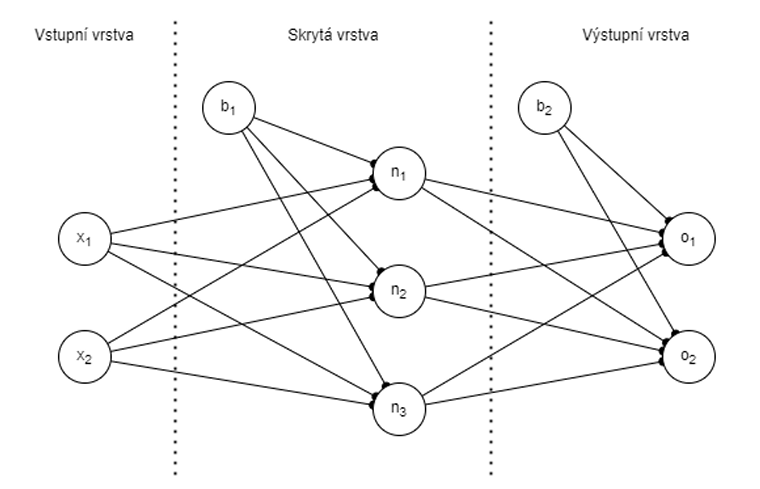

#### Data selection

- We use data with `_x` suffix, because we would like to use name of the attacker, victim and weapon from the `df_weapon_fires` dataframe.

In [11]:
X = df[["user_X_x", "user_Y_x", "weapon_x", "total_rounds_played"]]
y = df["player_died"]

In [12]:
X

,user_X_x,user_Y_x,weapon_x,total_rounds_played
0,1296.000000,32.000000,weapon_smokegrenade,0
1,-1372.368164,-977.939453,weapon_knife_karambit,0
2,-1921.021362,-325.519287,weapon_knife_karambit,0
3,386.088837,51.468979,weapon_flashbang,0
4,-1174.323120,-727.842529,weapon_usp_silencer,0
...,...,...,...,...
3127,-2260.312012,628.897278,weapon_deagle,17
3128,-2255.038330,627.889587,weapon_deagle,17
3129,-1801.680664,-54.884399,weapon_m4a1_silencer,17
3130,-1800.396851,-55.175659,weapon_m4a1_silencer,17


In [13]:
y

0       0
1       1
2       1
3       0
4       1
       ..
3127    0
3128    0
3129    0
3130    0
3131    0
Name: player_died, Length: 3132, dtype: int32

#### Data processing

One-hot encode the 'weapon_x' column (since it's categorical).

In [14]:
X = pd.get_dummies(X, columns=["weapon_x"])
X

,user_X_x,user_Y_x,total_rounds_played,weapon_x_weapon_ak47,weapon_x_weapon_awp,weapon_x_weapon_deagle,weapon_x_weapon_elite,weapon_x_weapon_flashbang,weapon_x_weapon_galilar,weapon_x_weapon_glock,...,weapon_x_weapon_knife_widowmaker,weapon_x_weapon_m4a1_silencer,weapon_x_weapon_mac10,weapon_x_weapon_molotov,weapon_x_weapon_mp9,weapon_x_weapon_p250,weapon_x_weapon_smokegrenade,weapon_x_weapon_ssg08,weapon_x_weapon_tec9,weapon_x_weapon_usp_silencer
0,1296.000000,32.000000,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,-1372.368164,-977.939453,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-1921.021362,-325.519287,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,386.088837,51.468979,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1174.323120,-727.842529,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,-2260.312012,628.897278,17,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3128,-2255.038330,627.889587,17,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3129,-1801.680664,-54.884399,17,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3130,-1800.396851,-55.175659,17,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


Scale data to improve the performance and convergence.

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.58971678,  0.94432862, -1.73770765, ..., -0.03575993,
        -0.09834216, -0.27419013],
       [-0.83079472, -0.09453845, -1.73770765, ..., -0.03575993,
        -0.09834216, -0.27419013],
       [-1.53409894,  0.57656893, -1.73770765, ..., -0.03575993,
        -0.09834216, -0.27419013],
       ...,
       [-1.38111921,  0.85495559,  1.7833376 , ..., -0.03575993,
        -0.09834216, -0.27419013],
       [-1.37947353,  0.85465599,  1.7833376 , ..., -0.03575993,
        -0.09834216, -0.27419013],
       [-1.43932117,  0.80974723,  1.7833376 , ..., -0.03575993,
        -0.09834216, -0.27419013]])

Data split for training and testing phases with training size of 80 %.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape

(2505, 27)

Model with three dense layers and one input layer with size of `X_train`.

- Input layer is used to define the input shape.
- Last layer uses **sigmoid** activation because of binary classification.

In [18]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

Compile the model.

In [19]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

Model training phase.

In [20]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6496 - loss: 0.6540 - val_accuracy: 0.7092 - val_loss: 0.5485
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7318 - loss: 0.5323 - val_accuracy: 0.7450 - val_loss: 0.5223
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7652 - loss: 0.4948 - val_accuracy: 0.7649 - val_loss: 0.5166
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7619 - loss: 0.4936 - val_accuracy: 0.7729 - val_loss: 0.5036
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4503 - val_accuracy: 0.7849 - val_loss: 0.4979
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7780 - loss: 0.4663 - val_accuracy: 0.7809 - val_loss: 0.4909
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.4568 - val_accuracy: 0.7610 - val_loss: 0.4928
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7864 - loss: 0.4481 - val_accuracy: 0.7610 - val_loss:

Testing phase by evaluating the model with testing data.

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7759 - loss: 0.4630
Model Accuracy: 0.7735247015953064


# Task 2

Create **two** different neural networks to predict some interesting situations that may affect the game.

Use the previous example for implementation.

Here are some examples:
- Predicting bomb plant in a game round - Predict if a bomb will be planted in a given round based on weapon fires, player positions, and past round data.
- Predicting the team to win a game round - Predict which team will win the round based on player actions and round data.
- Predicting player damage in a game round - Predict the total damage a player will deal in a round based on their actions and positioning.
- Predicting flashbang detonations effectiveness - Predict the effectiveness of a flashbang based on the number of players it flashes in a round.